# MNEflow basic calssification example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [1]:
#%pylab inline
#get epochs using your mne-python pipeline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import sys
import os
from time import time, strftime, gmtime
import gc

import numpy as np
import mne
from mne.datasets import multimodal

os.chdir('/m/nbe/project/rtmeg/problearn/mneflow/')
import mneflow
# from mneflow import keras_models
# from mneflow import keras_layers

from mneflow.keras_utils import plot_output, plot_history

# Force enable eager execution after importing mneflow
tf.compat.v1.enable_eager_execution()
mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]

epochs_list = [mne.Epochs(raw, **c) for c in cond]

epochs = mne.concatenate_epochs(epochs_list)

epochs = epochs.pick_types(meg='grad')
# print(epochs.info)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
sys.path
print('---------\n'+mneflow.__file__)
print('tf version: '+tf.__version__)
print('executing eagerly: '+str(tf.executing_eagerly())+'\n---------')

---------
/m/nbe/project/rtmeg/problearn/mneflow/mneflow/__init__.py
tf version: 2.0.0
executing eagerly: True
---------


### Convert epochs to TFRecord format

In [3]:
#Specify import options
import_opt = dict(savepath='/m/nbe/project/rtmeg/problearn/mneflow/tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks = {'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  val_size=0.2,  # validation set size set to 15% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')


#write TFRecord files and metadata file to disk
#meta = mneflow.produce_tfrecords([epochs],**import_opt)  
meta = mneflow.produce_tfrecords([epochs], **import_opt)  

processing epochs
Converting picks
input shapes: X- (940, 0, 361) targets- (940,)
training set: X- (752, 0, 302)  y- (752, 8)
validation set: X- (188, 0, 302)  y- (188, 8)
Prepocessed sample shape: (1, 302, 0)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [4]:
dataset = mneflow.Dataset(meta, train_batch=100, class_subset=None, pick_channels=None, decim=None)

AttributeError: in converted code:

    /m/nbe/project/rtmeg/problearn/mneflow/mneflow/data.py:167 _parse_function  *
        parsed_features = tf.parse_single_example(example_proto,

    AttributeError: module 'tensorflow' has no attribute 'parse_single_example'


# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. computational graph
3. optimizer

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.keras_models.Model for more details.
In this example will we use LF-CNN network


In [6]:
# specify model parameters
graph_specs = dict(n_ls=64,  # number of latent factors
                   filter_length=17,  # convolutional filter length
                   pooling=5,  # convlayer pooling factor
                   stride=5,  # stride parameter for pooling layer
                   padding='SAME',
                   dropout=.5,
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   y_shape=meta['y_shape'],
                   model_path = import_opt['savepath'],  # not used at the moment
                   # regularization parameters
                   l1=3e-4,
                   l2=0)


In [7]:
model = mneflow.models.LFCNN(graph_specs, dataset)

#specify optimizer parameters
# Based on keras, see documentation for keras.optimizers
optim = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss_f = tf.compat.v1.losses.softmax_cross_entropy

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=['accuracy'])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=1)



de-mix init : OK
fc init : OK


In [8]:
#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=3, steps_per_epoch=200,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

model.summary()

[None, 204, 302]
input x0 (?, 204, 302, 1)
de-mix built : OK
dmx (?, 302, 1, 64)
conv build : OK
f: (17, 1, 64, 1)
lf-out (?, 302, 1, 64)
conv (?, 302, 64)
fc ::: 19328 8
fc build : OK
call: y (?, 8)
(?, 8)
Train for 200 steps, validate for 1 steps
Epoch 1/3
[None, 204, 302]
input x0 (?, 204, 302, 1)
dmx (?, 302, 1, 64)
f: (17, 1, 64, 1)
lf-out (?, 302, 1, 64)
conv (?, 302, 64)
call: y (?, 8)
(?, 8)
[None, 204, 302]
input x0 (?, 204, 302, 1)
call: y (?, 8)
(?, 8)
111/200 [===============>..............] - ETA: 5s - loss: 1.7294 - acc: 0.6859

W0312 18:02:57.982584 139969787889408 callbacks.py:1286] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


KeyboardInterrupt: 

# 4. Explore the trained model parameters
LFCNN allows to interpret the trained parameters in terms of toporaphies and the spectral properties of the latent sources contributing to each class. 

In [8]:

model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)

ds batch size: 100
[100, 204, 302]
input x0 (100, 204, 302, 1)
dmx (100, 302, 1, 64)
out_w: (3904, 8)
demx: (204, 64) kern: (17, 64) tc_out: (100, 302, 64) out_w: (61, 64, 8)


ValueError: cannot reshape array of size 19328 into shape (61,64)

In [9]:
f3 = model.plot_spectra(sorting='best')

TypeError: list indices must be integers or slices, not tuple

[None, 204, 302]
input x0 (?, 204, 302, 1)


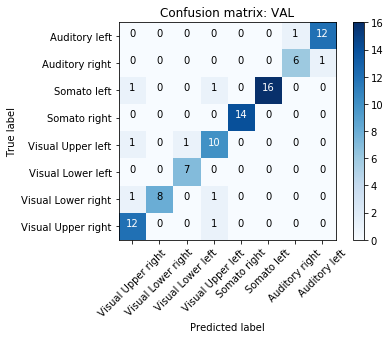

In [10]:
# Plotting the confusion matrix allows to identify analyze whether certain classes 
# are systematically harder to classify 
f2 = model.plot_cm(dataset, dset='val', steps=1, class_names=condition_names)

1/1 [==============================] - 0s 255ms/step - loss: 0.8776 - acc: 0.8404


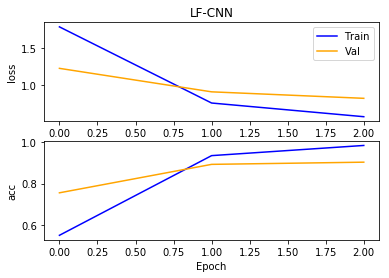

In [11]:
results = model.evaluate(dataset.test, steps=1, verbose=1)
model.plot_history()

# 5. LFLSTM

In [ ]:
# specify model parameters
graph_specs = dict(n_ls=64,  # number of latent factors
                   filter_length=17,  # convolutional filter length
                   pooling=5,  # convlayer pooling factor
                   stride=5,  # stride parameter for pooling layer
                   padding='SAME',
                   dropout=.5,
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   y_shape=meta['y_shape'],
                   model_path = import_opt['savepath'],  # not used at the moment
                   # regularization parameters
                   l1=3e-4,
                   l2=0,
                   # LSTM parameters
                   rnn_units=np.prod(meta['y_shape']),
                   rnn_dropout=0.0,
                   rnn_nonlin='tanh',
                   rnn_rec_nonlin='tanh',
                   rnn_forget_bias=True,
                   rnn_seq=True,
                   unroll=False)

model = keras_models.LFLSTM(graph_specs, dataset)

#specify optimizer parmeters
optim = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss_f = tf.compat.v1.losses.softmax_cross_entropy

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=['accuracy'])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=1)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=10, steps_per_epoch=200,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

model.summary()

In [ ]:
model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)

In [ ]:
f3 = model.plot_spectra(sorting='best')

In [ ]:
#Plotting the confusion matrix allows to identify analyze whether cetrain classes 
#are systematically harder to classify 
f2 = model.plot_cm(dataset, dset='train', steps=1, class_names=condition_names)

In [ ]:
results = model.evaluate(dataset.test, steps=1, verbose=1)
model.plot_history()